# Assignment 2


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* vnes
* deck
* 

---

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## Problem 1: Design the Optimal Peak Detection System (3pts)

A common problem in the analysis event data is the precise localization of a peak with a known form, say a Gaussian. We generally have two options. 

1. We can perform direct density estimation given the known parametric form, which is equivalent to a GMM with $K=1$. 
2. We can form a histogram, which turns event locations into counts per bin, and then fit a Gaussian to the pairs $(x_k, N_k)$ of (mean) bin location and counts. 

**Side note:** 
For image analysis, where the peak could be e.g. a small tree on a satellite photo, we have don't have that choice. It's always option 2 because the incoming photons are automatically binned into pixels by the detector in the camera.

### Step 1 (2pts)

Compare the uncertainty of the center estimation in these two cases as a function of the total event number $N$. Specifically, assume a standard normal distribution (i.e. $\sigma=1$) for the generating process. Draw $N$ events. 

For case 1, determine the mean $\tilde\mu$ of the event distribution.
For case 2, bin the samples with a bin width $\Delta=1$. That gives you a set of bin centers and counts $\mathcal{D}=\lbrace (x_1,N_1), \dots, (x_K,N_K)\rbrace$. The likelihood for each bin is Poissonian, with a mean rate $\lambda_k$ that follows a Gaussian parametric form. But the Gaussian shape also needs to be integrated in the bins:

$$
\lambda_k = \frac{N}{\sqrt{2\pi}\sigma} \int_{x_k - \Delta/2}^{x_k + \Delta/2} \exp\left(-\frac{1}{2\sigma^2}(x - \mu)^2\right) dx = \frac{N}{2} \left[\mathrm{erf}\left(\frac{\Delta/2 - (x_k - \mu)}{\sqrt{2} \sigma}\right) + \mathrm{erf}\left(\frac{x_k - \mu + \Delta/2}{\sqrt{2} \sigma}\right)\right]
$$

for some unknown $\mu$. $\mathrm{erf}$ stands for the [Error function](https://en.wikipedia.org/wiki/Error_function). Use `scipy.optimize` to find the MLE $\tilde\mu_b$. 

Repeat the process multiple times, plot $p(\tilde\mu)$ and $p(\tilde\mu_b)$, and compute their mean and variances. Repeat with different $N$.

(array([  8.,  41., 123., 214., 258., 209., 103.,  29.,  13.,   2.]),
 array([-2.96784054, -2.29553315, -1.62322576, -0.95091837, -0.27861098,
         0.3936964 ,  1.06600379,  1.73831118,  2.41061857,  3.08292596,
         3.75523335]),
 <BarContainer object of 10 artists>)

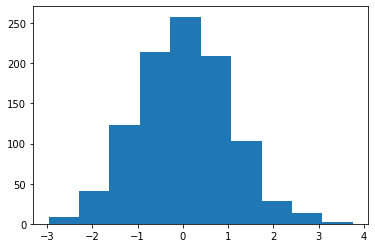

In [15]:
#1 direct density estimation

#2 histogram
N=1000
delta = 1
draws = np.random.randn(N)
plt.hist(draws)

from scipy import optimize

### Step 2 (1pt)

Assume that your instrument only reports binned event counts. Determine the MLE of the bin width $\Delta$ as a function of the sample size $N$.

## Problem 2: Clustering Hyper-Spectral Images (3pts)

Hyper-spectral images of a scene are recorded in hundreds of wavelengths, typically extending beyond the range perceptible by humans. They play a critical role in remote sensing from aerial and satellite platforms because they allow us to infer e.g. where roads or vegetation are (even under clouds), how well crops grow, the salinity of water...

Often, we don't know a priori what is recorded in a particular hyper-spectral data set. Unsupervised clustering is then a way to identify interesting structures. Download [this](https://github.com/fred3m/hyperspectral/blob/master/data/subset.npy) hyper-spectral data set, [taken from an airplane](https://doi.org/10.1117/12.157055) flying over Capitol Hill in Washington, D.C. It consists of 191 spectral channels, each having 200 x 200 pixels. Then pick 2 different clustering algorithms and attempt to identify interesting structures. This will typically require some tinkering with parameter settings. When done, compare what the two clustering algorithms found and try to explain why the outcomes differ on the basis of the assumptions made by the algorithms.

**Hint:** The data are stored in the layout `(N_channels, N_pixels)`, with each 2D image flattened into a single long vector. This treats every channel as an independent sample with a vector of intensity variations per pixel. Alternatively, you can flip the axes into the layout `(N_pixels, N_channels)`, which treat every pixel as an independent sample with a vector of intensity variations per channel. Both of these are valid, as are hybrids and subsets. Decide which of them you want to use.

**Hint 2:** For visualization, it's best to reshape the pixel vector from `(N_pixels)` to `(N_pixels_vertical, N_pixels_horizontal)`. Also, Google Map/Earth could turn out to be useful for your visual orientation.

In [12]:
plane_data = np.load("subset.npy")
plane_data.shape
#decide whether or not to transpose

(191, 40000)

## Problem 3: Survey Responses - The Good, the Bad, and the Ugly (4pts)

Questionnaires, especially online, are often contaminated with incorrect answers, which come in two main forms: malice or lack of interest. For any single question, it is impossible to infer the motivations of a user from their response, but with multiple questions it should be doable. Let's find out with the data in `questionnaire.npy`, which contains 7 Yes/No questions for 100 users.

### Step 1 (3pts)

Assume a mixture model with 3 groups: 

* the Good $G$: users who try to answer the questions
* the Bad $B$: users who don't seem to pay attention
* the Ugly $U$: users who intentionally try to answer the questions incorrectly

Because of the binary nature of the question, the base distributions are of the Binomial type.

Review Murphy 11.2.2 and Exercise 11.3.
Then code your own EM algorithm to solve for the posterior weights $\pi_k$ and mean probabilities $\mu_{jk}$ of each question.
Think about whether you can put non-trivial priors on the component weights.

Try to identify which of the components describes $G$. 
Then report the the posterior weights as well as the mean and variances of the Binomial distribution parameter $\mu_j$ for every question $j$ *only* for the users you believe to be in $G$.

**Hint**: Not every user has the same behavior and motivation. Think about how each user group is expected to perform in the survey, and decide which one is $G$. Plotting the means might help.

**Hint 2**: Pay attention to the value of the $\mu_k$. The log likelihood is ill-defined if $\mu_k\in\{0,1\}$.

### Step 2 (1pts)

Now that you have identified the groups, rerun the the EM with a prior on the cluster assignments:
$p(z_i=G)=0.8$, $p(z_i=B)=0.1$, $p(z_i=U)=0.1\forall i$. Plot the results.

Can you construct an alternative estimator of $\mu_j$ using not just the result for $G$? If so, what is the analytic form of this estimator?